#  dataset description and overview

[link](https://ogb.stanford.edu/docs/nodeprop/)


Graph: The ogbn-arxiv dataset is a directed graph, representing the citation network between all Computer Science (CS) arXiv papers indexed by MAG [1]. Each node is an arXiv paper and each directed edge indicates that one paper cites another one. Each paper comes with a __128-dimensional feature vector__ obtained by averaging the embeddings of words in its title and abstract. The embeddings of individual words are computed by running the skip-gram model [2] over the MAG corpus. We also provide the mapping from MAG paper IDs into the raw texts of titles and abstracts here. In addition, all papers are also associated with the year that the corresponding paper was published.

Prediction task: The task is __to predict the 40 subject areas__ of arXiv CS papers, e.g., cs.AI, cs.LG, and cs.OS, which are manually determined (i.e., labeled) by the paper’s authors and arXiv moderators. With the volume of scientific publications doubling every 12 years over the past century, it is practically important to automatically classify each publication’s areas and topics. Formally, the task is to predict the primary categories of the arXiv papers, which is formulated as a 40-class classification problem.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ModuleList, Linear, BatchNorm1d
import torch.optim as optim
import numpy as np
## for GNN manner
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, JumpingKnowledge
from torch_geometric.data import NeighborSampler
import torch_geometric.transforms as T
# for MLP manner
import torch_geometric.transforms as T
from torch_geometric.nn import MLP, CorrectAndSmooth

from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
# from logger import Logger

import umap
import matplotlib.pyplot as plt

# MLP manner

## [resource](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/correct_and_smooth.py)

In [12]:
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='./arxiv/', transform=T.ToSparseTensor())
evaluator = Evaluator(name='ogbn-arxiv')
split_idx = dataset.get_idx_split()

train_idx = split_idx['train']
test_idx = split_idx['test']

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP([dataset.num_features, 200, 200, dataset.num_classes],
           dropout=0.5,
           batch_norm=True,
           act_first=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [18]:
data = dataset[0]

In [19]:
x, y = data.x.to(device), data.y.to(device)
train_idx = split_idx['train'].to(device)
val_idx = split_idx['valid'].to(device)
test_idx = split_idx['test'].to(device)
x_train, y_train = x[train_idx], y[train_idx]

In [22]:
x , y

(tensor([[-0.0579, -0.0525, -0.0726,  ...,  0.1734, -0.1728, -0.1401],
         [-0.1245, -0.0707, -0.3252,  ...,  0.0685, -0.3721, -0.3010],
         [-0.0802, -0.0233, -0.1838,  ...,  0.1099,  0.1176, -0.1399],
         ...,
         [-0.2205, -0.0366, -0.4022,  ...,  0.1134, -0.1614, -0.1452],
         [-0.1382,  0.0409, -0.2518,  ..., -0.0893, -0.0413, -0.3761],
         [-0.0299,  0.2684, -0.1611,  ...,  0.1208,  0.0776, -0.0910]],
        device='cuda:0'),
 tensor([[ 4],
         [ 5],
         [28],
         ...,
         [10],
         [ 4],
         [ 1]], device='cuda:0'))

In [38]:
print(f'the node feature emb size {x[0].size()[0]} \n\n')

print(f'lable counts \t {len(torch.unique(y))}')

the node feature emb size 128 


lable counts 	 40


In [20]:
train_idx, val_idx , test_idx

(tensor([     0,      1,      2,  ..., 169145, 169148, 169251], device='cuda:0'),
 tensor([   349,    357,    366,  ..., 169185, 169261, 169296], device='cuda:0'),
 tensor([   346,    398,    451,  ..., 169340, 169341, 169342], device='cuda:0'))

In [21]:
x_train, y_train

(tensor([[-0.0579, -0.0525, -0.0726,  ...,  0.1734, -0.1728, -0.1401],
         [-0.1245, -0.0707, -0.3252,  ...,  0.0685, -0.3721, -0.3010],
         [-0.0802, -0.0233, -0.1838,  ...,  0.1099,  0.1176, -0.1399],
         ...,
         [-0.0462,  0.1187, -0.0900,  ...,  0.0142,  0.0565, -0.0999],
         [-0.1298, -0.0809, -0.1191,  ...,  0.1902,  0.0506, -0.1477],
         [-0.0273,  0.0055, -0.1226,  ..., -0.0410, -0.1121, -0.2353]],
        device='cuda:0'),
 tensor([[ 4],
         [ 5],
         [28],
         ...,
         [28],
         [23],
         [22]], device='cuda:0'))

In [40]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(x_train)
    loss = criterion(out, y_train.view(-1))
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(out=None):
    model.eval()
    out = model(x) if out is None else out
    pred = out.argmax(dim=-1, keepdim=True)
    train_acc = evaluator.eval({
        'y_true': y[train_idx],
        'y_pred' : pred[train_idx]
    })['acc']
    val_acc = evaluator.eval({
        'y_true': y[val_idx],
        'y_pred': pred[val_idx]
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y[test_idx],
        'y_pred': pred[test_idx]
    })['acc']
    return train_acc, val_acc, test_acc, out

In [41]:
best_val_acc = 0
for epoch in range(1, 301):
    loss = train()
    train_acc, val_acc, test_acc, out = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        y_soft = out.softmax(dim=-1)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 4.0278, Train: 0.2698, Val: 0.3395, Test: 0.3766
Epoch: 002, Loss: 3.0304, Train: 0.3288, Val: 0.3807, Test: 0.4121
Epoch: 003, Loss: 2.5337, Train: 0.3346, Val: 0.3455, Test: 0.3814
Epoch: 004, Loss: 2.3077, Train: 0.3324, Val: 0.3454, Test: 0.3814
Epoch: 005, Loss: 2.1919, Train: 0.3519, Val: 0.3955, Test: 0.4206
Epoch: 006, Loss: 2.1275, Train: 0.3596, Val: 0.4086, Test: 0.4265
Epoch: 007, Loss: 2.0784, Train: 0.3490, Val: 0.3831, Test: 0.4057
Epoch: 008, Loss: 2.0466, Train: 0.3354, Val: 0.3471, Test: 0.3724
Epoch: 009, Loss: 2.0127, Train: 0.3245, Val: 0.3257, Test: 0.3564
Epoch: 010, Loss: 1.9928, Train: 0.3209, Val: 0.3256, Test: 0.3588
Epoch: 011, Loss: 1.9702, Train: 0.3232, Val: 0.3331, Test: 0.3673
Epoch: 012, Loss: 1.9529, Train: 0.3247, Val: 0.3395, Test: 0.3727
Epoch: 013, Loss: 1.9388, Train: 0.3254, Val: 0.3406, Test: 0.3755
Epoch: 014, Loss: 1.9219, Train: 0.3292, Val: 0.3455, Test: 0.3794
Epoch: 015, Loss: 1.9111, Train: 0.3383, Val: 0.3574, Test: 0.

Epoch: 129, Loss: 1.6192, Train: 0.5691, Val: 0.5581, Test: 0.5340
Epoch: 130, Loss: 1.6146, Train: 0.5703, Val: 0.5603, Test: 0.5357
Epoch: 131, Loss: 1.6156, Train: 0.5700, Val: 0.5611, Test: 0.5369
Epoch: 132, Loss: 1.6153, Train: 0.5697, Val: 0.5595, Test: 0.5360
Epoch: 133, Loss: 1.6128, Train: 0.5705, Val: 0.5582, Test: 0.5358
Epoch: 134, Loss: 1.6109, Train: 0.5701, Val: 0.5582, Test: 0.5356
Epoch: 135, Loss: 1.6136, Train: 0.5704, Val: 0.5573, Test: 0.5319
Epoch: 136, Loss: 1.6111, Train: 0.5703, Val: 0.5579, Test: 0.5330
Epoch: 137, Loss: 1.6120, Train: 0.5719, Val: 0.5597, Test: 0.5371
Epoch: 138, Loss: 1.6088, Train: 0.5719, Val: 0.5606, Test: 0.5396
Epoch: 139, Loss: 1.6133, Train: 0.5711, Val: 0.5587, Test: 0.5370
Epoch: 140, Loss: 1.6101, Train: 0.5708, Val: 0.5586, Test: 0.5370
Epoch: 141, Loss: 1.6117, Train: 0.5713, Val: 0.5588, Test: 0.5354
Epoch: 142, Loss: 1.6105, Train: 0.5715, Val: 0.5605, Test: 0.5387
Epoch: 143, Loss: 1.6070, Train: 0.5732, Val: 0.5618, Test: 0.

Epoch: 259, Loss: 1.5697, Train: 0.5875, Val: 0.5680, Test: 0.5508
Epoch: 260, Loss: 1.5655, Train: 0.5877, Val: 0.5686, Test: 0.5531
Epoch: 261, Loss: 1.5680, Train: 0.5869, Val: 0.5697, Test: 0.5535
Epoch: 262, Loss: 1.5676, Train: 0.5887, Val: 0.5673, Test: 0.5488
Epoch: 263, Loss: 1.5656, Train: 0.5877, Val: 0.5669, Test: 0.5463
Epoch: 264, Loss: 1.5664, Train: 0.5884, Val: 0.5675, Test: 0.5477
Epoch: 265, Loss: 1.5662, Train: 0.5876, Val: 0.5679, Test: 0.5517
Epoch: 266, Loss: 1.5649, Train: 0.5878, Val: 0.5670, Test: 0.5506
Epoch: 267, Loss: 1.5672, Train: 0.5882, Val: 0.5656, Test: 0.5451
Epoch: 268, Loss: 1.5650, Train: 0.5883, Val: 0.5659, Test: 0.5449
Epoch: 269, Loss: 1.5622, Train: 0.5885, Val: 0.5676, Test: 0.5494
Epoch: 270, Loss: 1.5671, Train: 0.5893, Val: 0.5694, Test: 0.5527
Epoch: 271, Loss: 1.5627, Train: 0.5898, Val: 0.5680, Test: 0.5501
Epoch: 272, Loss: 1.5656, Train: 0.5894, Val: 0.5653, Test: 0.5441
Epoch: 273, Loss: 1.5658, Train: 0.5892, Val: 0.5668, Test: 0.

In [43]:
data.adj_t

SparseTensor(row=tensor([     0,      0,      0,  ..., 169341, 169341, 169341]),
             col=tensor([   411,    640,   1162,  ...,  30351,  35711, 103121]),
             size=(169343, 169343), nnz=1166243, density=0.00%)

In [47]:
adj_t = data.adj_t.to(device)
deg = adj_t.sum(dim=1).to(torch.float)
print(deg)
deg_inv_sqrt = deg.pow_(-0.5)
print(deg_inv_sqrt)
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
print(deg_inv_sqrt)
DAD = deg_inv_sqrt.view(-1, 1) * adj_t * deg_inv_sqrt.view(1, -1)
DA = deg_inv_sqrt.view(-1, 1) * deg_inv_sqrt.view(-1, 1) * adj_t

tensor([289.,   1.,   5.,  ...,   1.,   3.,   0.], device='cuda:0')
tensor([0.0588, 1.0000, 0.4472,  ..., 1.0000, 0.5774,    inf], device='cuda:0')
tensor([0.0588, 1.0000, 0.4472,  ..., 1.0000, 0.5774, 0.0000], device='cuda:0')


In [ ]:
# if you face the error about 'OOM' , first solution ; downsize your batch size, or
## apply below codes for memory empty.
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

In [48]:
post = CorrectAndSmooth(num_correction_layers = 50,
                       correction_alpha=1.0,
                       num_smoothing_layers=50,
                       smoothing_alpha=0.8,
                       autoscale=False,
                       scale=20.)

In [55]:
y.size()

torch.Size([169343, 1])

## correct

In [49]:
y_soft = post.correct(y_soft, y_train, train_idx, DAD)
y_soft.size()

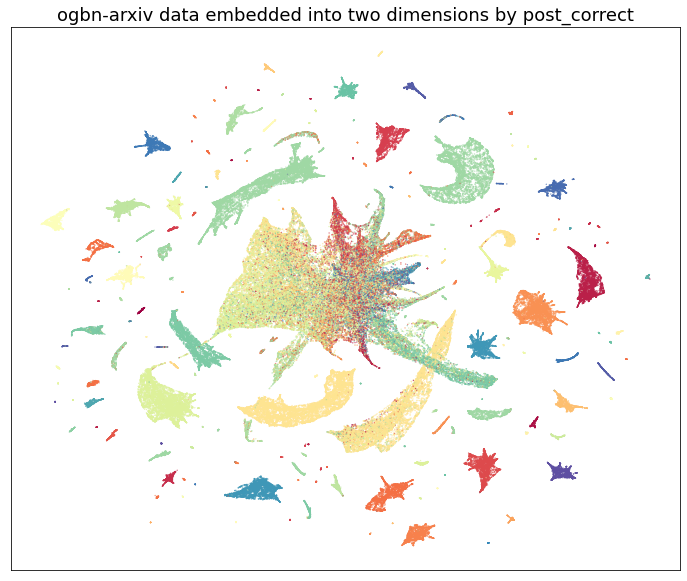

In [65]:
reducer = umap.UMAP(random_state=42, n_components=2)
embedding = reducer.fit_transform(y_soft.detach().cpu().numpy())
fig, ax = plt.subplots(figsize=(12, 10))
color = y.detach().cpu().numpy().astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("ogbn-arxiv data embedded into two dimensions by post_correct", fontsize=18)

plt.show()

## smooth

In [66]:
y_soft = post.smooth(y_soft, y_train, train_idx, DA)
y_soft.size()

torch.Size([169343, 40])

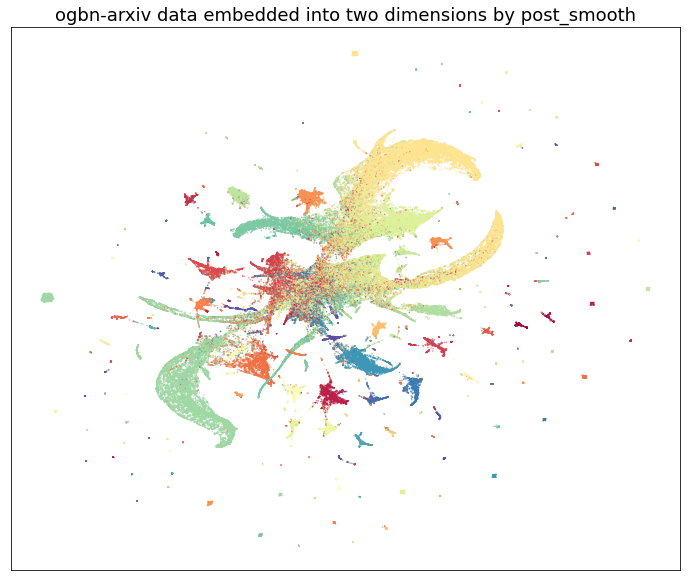

In [67]:
reducer = umap.UMAP(random_state=42, n_components=2)
embedding_smooth = reducer.fit_transform(y_soft.detach().cpu().numpy())

fig, ax = plt.subplots(figsize=(12, 10))
color = y.detach().cpu().numpy().astype(int)
plt.scatter(embedding_smooth[:, 0], embedding_smooth[:, 1], c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("ogbn-arxiv data embedded into two dimensions by post_smooth", fontsize=18)

plt.show()

## results

In [93]:
train_acc, val_acc, test_acc, _ = test(y_soft)
print(f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Train: 0.9728, Val: 0.6215, Test: 0.5804


## prior results ; Train: 0.5911, Val: 0.5655, Test: 0.5476


## post results ; Train: 0.9728, Val: 0.6215, Test: 0.5804

# Optional)

UMAP - GPU version

- if you want to more faster than before, read this and utilize RAPIDS library, but you might experience the environment setup problem :)

- [link](https://medium.com/the-artificial-impostor/umap-on-rapids-15x-speedup-f4eabfbdd978)

# GNN manner

## [resource](https://github.com/ytchx1999/GCN_res-CS-v2/blob/main/gcn_res_cs.py)

In [122]:
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='./arxiv/', transform=T.ToSparseTensor())
data = dataset[0]

In [125]:
class GCNNet(nn.Module):
    def __init__(self, dataset, hidden=256, num_layers=3):
        """
        :param dataset: 数据集
        :param hidden: 隐藏层维度，默认256
        :param num_layers: 模型层数，默认为3
        """
        super(GCNNet, self).__init__()

        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.convs.append(GCNConv(dataset.num_node_features, hidden))
        self.bns.append(nn.BatchNorm1d(hidden))

        for i in range(self.num_layers - 2):
            self.convs.append(GCNConv(hidden, hidden))
            self.bns.append(nn.BatchNorm1d(hidden))

        self.convs.append(GCNConv(hidden, dataset.num_classes))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, data):
        x, adj_t = data.x, data.adj_t

        for i in range(self.num_layers - 1):
            x = self.convs[i](x, adj_t)
            x = self.bns[i](x)  # 小数据集不norm反而效果更好
            x = F.relu(x)
            x = F.dropout(x, p=0.5, training=self.training)

        x = self.convs[-1](x, adj_t)
        x = F.log_softmax(x, dim=1)

        return x

RuntimeError: mat1 and mat2 shapes cannot be multiplied (169343x256 and 128x256)

In [126]:
model = GCNNet(dataset=dataset, hidden=256, num_layers=3)
print(model)

GCNNet(
  (convs): ModuleList(
    (0): GCNConv(128, 256)
    (1): GCNConv(256, 256)
    (2): GCNConv(256, 40)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [127]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
data = data.to(device)
data.adj_t = data.adj_t.to_symmetric()

cuda


In [128]:
x, y = data.x.to(device), data.y.to(device)
train_idx = split_idx['train'].to(device)
val_idx = split_idx['valid'].to(device)
test_idx = split_idx['test'].to(device)
x_train, y_train = x[train_idx], y[train_idx]

In [132]:
adj_t = data.adj_t.to(device)
deg = adj_t.sum(dim=1).to(torch.float)
deg_inv_sqrt = deg.pow_(-0.5)
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
DAD = deg_inv_sqrt.view(-1, 1) * adj_t * deg_inv_sqrt.view(1, -1)
DA = deg_inv_sqrt.view(-1, 1) * deg_inv_sqrt.view(-1, 1) * adj_t
AD = adj_t * deg_inv_sqrt.view(-1, 1) * deg_inv_sqrt.view(-1, 1)

In [133]:
criterion = nn.NLLLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [134]:
def train():
    model.train()

    out = model(data)
    loss = criterion(out[train_idx], data.y.squeeze(1)[train_idx])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [135]:
@torch.no_grad()
def test(out=None):
    model.eval()

    out = model(data) if out is None else out
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc, out

In [ ]:
for epoch in range(300):
    loss = train()
    # print('Epoch {:03d} train_loss: {:.4f}'.format(epoch, loss))

    train_acc, val_acc, test_acc, out = test()
    result = (train_acc, val_acc, test_acc)
    # print(f'Train: {train_acc:.4f}, Val: {valid_acc:.4f}, 'f'Test: {test_acc:.4f}')
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        y_soft = out.softmax(dim=-1)

    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * val_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

In [137]:
# post = CorrectAndSmooth(num_correction_layers=50, correction_alpha=1.0,
#                         num_smoothing_layers=50, smoothing_alpha=0.8,
#                         autoscale=False, scale=20.)

post = CorrectAndSmooth(num_correction_layers=50, correction_alpha=0.7,
                        num_smoothing_layers=50, smoothing_alpha=0.7,
                        autoscale=False, scale=1.)

print('Correct and smooth...')
# y_soft = post.correct(y_soft, y_train, train_idx, DAD)
# y_soft = post.smooth(y_soft, y_train, train_idx, DA)
y_soft = post.correct(y_soft, y_train, train_idx, DAD)
y_soft = post.smooth(y_soft, y_train, train_idx, DAD)
print('Done!')
train_acc, val_acc, test_acc, _ = test(y_soft)
print(f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

result = (train_acc, val_acc, test_acc)

Correct and smooth...
Done!
Train: 0.9831, Val: 0.7384, Test: 0.7260


Train: 77.45% , Valid: 72.72% , Test: 71.83%

Train: 98.31% , Valid: 73.84% , Test: 72.60%

# CONCLUSION

## the MLP results ;

- prior results ; Train: 0.5911, Val: 0.5655, Test: 0.5476

- post results ; Train: 0.9728, Val: 0.6215, Test: 0.5804


## the GNN results ; 

- prior results ; Train: 77.45% , Valid: 72.72% , Test: 71.83%

- post results ; Train: 98.31% , Valid: 73.84% , Test: 72.60%


# code by jeongiitae6@gmail.com

if u have a question , give me the email above address. :)